<a href="https://colab.research.google.com/github/BatoolMM/PlantAI/blob/master/PlantAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
!pip install -Uqq fastbook
!pip install fastcore==1.0.9
!pip install utils
!pip install azure-cognitiveservices-search-imagesearch

In [13]:
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import ImageClassifierCleaner
from utils import *
import os
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth
#fastbook.setup_book()
import ipywidgets as widgets
from IPython.display import display, HTML
from fastai.callback.all import *
import pandas as pd
from functools import partial


In [14]:
def search_images_bing(key, term, min_sz=128):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term, count=150, min_height=min_sz, min_width=min_sz).value)
key = '8d86a0d22d7643549e560f18abfe8fde'
key2 ='d5851efce83544c6a29b96a7341f28dd'

def highlight(s, usemax=True):    
    if usemax:
        is_max = s == s.max()
    else:
        is_max = s == s.min()
    return ['text-decoration: underline;' if v else '' for v in is_max]

class ColorfulProgressCallback(ProgressCallback):
    def __init__(self):
        super()
        
    def begin_fit(self):
        super().begin_fit()
        if(hasattr(self, 'out')): delattr(self, 'out')
        for i, cb in enumerate(self.learn.cbs):
            if type(cb) == ProgressCallback:
                self.learn.cbs[i] = self
            
    def after_fit(self):
        super().after_fit()
        if(hasattr(self, 'all_log')): delattr(self, 'all_log')
        
    def _write_stats(self, log):
        if(not hasattr(self, 'all_log')):
            self.all_log = pd.DataFrame([], columns=log)
            return
        
        self.all_log.loc[len(self.all_log)] = [l if isinstance(l, float) else str(l) for l in log]
        for c in self.all_log.columns[1:-1]:
            self.all_log[c] = self.all_log[c].astype(float)
            
        s = self.all_log.style
        for c in self.all_log.columns[1:-1]:
            isR2 = 'R2' in c
            low = .8 if isR2 else .2
            high = .2 if isR2 else .8
            s = s.background_gradient(cmap=f'viridis{"_r" if not isR2 else ""}', subset=c, low=low, high=high)
            s.apply(partial(highlight, usemax=isR2), subset=[c])
        s = s.hide_index()
        
        if(hasattr(self, 'out')):
            self.out.update(s)
        else:
            self.out = display(s, display_id=True)


In [4]:
plants_type = 'Dieffenbachia', 'Schefflera', 'Dracaena', 'Epipremnum aureum'
path = Path('plants_new')

if not path.exists():
    path.mkdir()
    for o in plants_type:
      dest = (path/o)
      dest.mkdir(exist_ok =True)
      results = search_images_bing(key, f'{o} plant')
      download_images(dest, urls = results.attrgot('content_url'))


 Download of http://dawsonsgardenworld.com.au/wp-content/uploads/2015/08/Schefflera-Arboricola-.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p plants_new/Schefflera
$ cd plants_new/Schefflera
$ wget -c http://dawsonsgardenworld.com.au/wp-content/uploads/2015/08/Schefflera-Arboricola-.jpg
$ tar xf Schefflera-Arboricola-.jpg
 And re-run your code once the download is successful



In [5]:
files = get_image_files(path)
files

(#590) [Path('plants_new/Epipremnum aureum/00000006.jpg'),Path('plants_new/Epipremnum aureum/00000050.jpg'),Path('plants_new/Epipremnum aureum/00000004.jpg'),Path('plants_new/Epipremnum aureum/00000023.jpg'),Path('plants_new/Epipremnum aureum/00000025.jpg'),Path('plants_new/Epipremnum aureum/00000099.jpg'),Path('plants_new/Epipremnum aureum/00000017.jpg'),Path('plants_new/Epipremnum aureum/00000062.jpg'),Path('plants_new/Epipremnum aureum/00000103.JPG'),Path('plants_new/Epipremnum aureum/00000132.jpg')...]

In [6]:
failed = verify_images(files)
failed

(#7) [Path('plants_new/Schefflera/00000023.jpg'),Path('plants_new/Schefflera/00000144.jpg'),Path('plants_new/Schefflera/00000012.jpg'),Path('plants_new/Schefflera/00000020.jpg'),Path('plants_new/Schefflera/00000095.jpg'),Path('plants_new/Dieffenbachia/00000089.jpg'),Path('plants_new/Dracaena/00000076.jpg')]

In [7]:
failed.map(Path.unlink)

(#7) [None,None,None,None,None,None,None]

In [8]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [9]:
data = data.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())


In [20]:
dls = data.dataloaders(path)
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4, cbs=[ColorfulProgressCallback()])

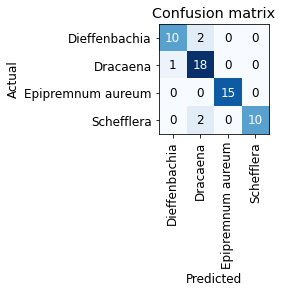

In [21]:
interpret = ClassificationInterpretation.from_learner(learn)
interpret.plot_confusion_matrix()

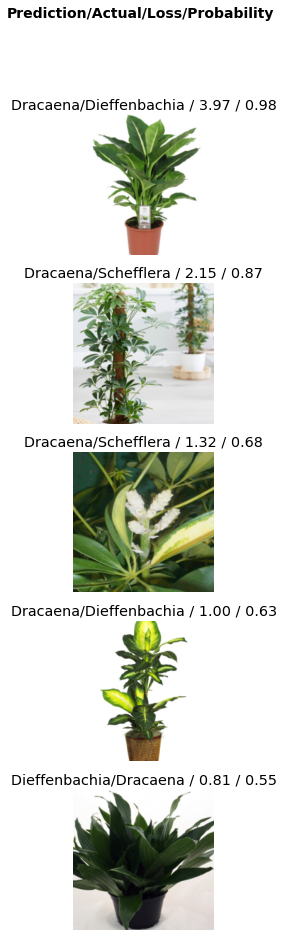

In [22]:
interpret.plot_top_losses(5,nrows=5)

In [23]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [24]:
for idx in cleaner.delete():
  cleaner.fns[idx].unlink()

In [26]:
dls = data.dataloaders(path)
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5, cbs=[ColorfulProgressCallback()])

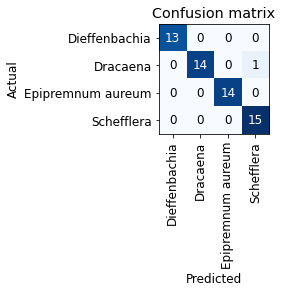

In [27]:
interpret = ClassificationInterpretation.from_learner(learn)
interpret.plot_confusion_matrix()

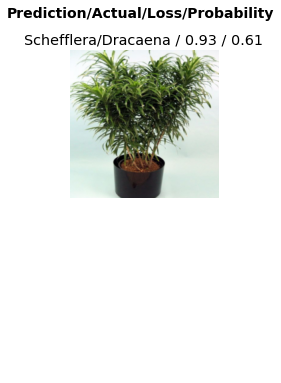

In [29]:
interpret.plot_top_losses(1,nrows=2)

In [30]:
learn.export()